<a href="https://colab.research.google.com/github/AnyashaTk/AnalysTextProject/blob/main/EvgAnnROBERTaNet_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.0.2

     |████████████████████████████████| 778kB 28.1MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 
     |████████████████████████████████| 1.2MB 39.4MB/s 
     |████████████████████████████████| 3.0MB 38.9MB/s 


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
# подключение гугл-диска
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# загрузка файла с гугл диска
!cp '/content/gdrive/My Drive/Colab Notebooks/Twitter/df_neg.csv' df_neg.csv
!cp '/content/gdrive/My Drive/Colab Notebooks/Twitter/df_pos.csv' df_pos.csv

In [ ]:
import pandas as pd
pos_norm_csv = pd.read_csv('df_pos.csv')

In [ ]:
for i in range(len(pos_norm_csv['label'])):
  pos_norm_csv['label'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pos_norm_csv

,text,label
0,I LOVE @Health4UandPets u guys r the best!!,1
1,im meeting up with one of my besties tonight! ...,1
2,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
3,Being sick can be really cheap when it hurts t...,1
4,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
799995,Just woke up. Having no school is the best fee...,1
799996,TheWDB.com - Very cool to hear old Walt interv...,1
799997,Are you ready for your MoJo Makeover? Ask me f...,1
799998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [ ]:
train =pd.concat([ pd.read_csv('df_neg.csv').dropna()[:][:3000],pos_norm_csv.dropna()[:][:3000]])


In [ ]:
train.shape


(6000, 2)

In [ ]:
train.head()

,text,label
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [ ]:
train['label'].unique()

array([0, 1])

In [ ]:
train.describe()

,label
count,6000.000000
mean,0.500000
std,0.500042
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
new_df = train[['text', 'label']]

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32               
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (6000, 2)
TRAIN Dataset: (4800, 2)
TEST Dataset: (220, 2)


In [ ]:
train_data['text']

0       @Heidi_Volturi see there you go again laughing...
1       @Brandizzzle08 yoyoyo. my internet has been ru...
2       @Malunis Ohh! Classics Armada. I'd want the Se...
3       @krist0ph3r thats damn sad   hope things will ...
4               @TerryFree Thanks.    Appreciate that....
                              ...                        
4795    @naughtyhaughty I had on my page for sooooo lo...
4796                                 @JessicaFilan it is 
4797    My stress always culminates with physical pain.  
4798                 @jazz_nash ahaha im sure it is. lol 
4799    @amazondotjon http://twitpic.com/2xx4r - sweee...
Name: text, Length: 4800, dtype: object

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, eleme

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

import matplotlib.pyplot as plt
from IPython.display import clear_output
# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []


# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_accuracy_set = []

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%10==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            #print(f"Training Loss per 1000 steps: {loss_step}")
            #print(f"Training Accuracy per 1000 steps: {accu_step}")

            # Добавление в массивы для отображения графика
            train_loss_set.append(loss_step) 
            train_accuracy_set.append(accu_step)
            # Рисуем график
            clear_output(True)
            plt.plot(train_loss_set,  color='blue')
            plt.plot(train_accuracy_set,  color='orange')
            plt.title("Training loss")
            plt.xlabel("Batch")
            plt.ylabel("Loss and Accuracy") 
            
            plt.show()

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

       


     

    #print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

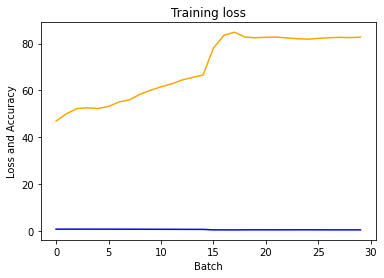

150it [03:30,  1.41s/it]

Training Loss Epoch: 0.3950574309627215
Training Accuracy Epoch: 82.77083333333333


In [ ]:
EPOCHS = 2
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
test_loss_set = []
test_accuracy_set = []
import sklearn
from sklearn.metrics import confusion_matrix

def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            #print(outputs.data)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            # big_idx - резултьат предсказания, а targets - ожидаемое предсказание
            n_correct += calcuate_accuracy(big_idx, targets)
            
            print(outputs.data, big_idx, targets)

            



            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%10==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
                big = big_idx.cpu()
                tar = targets.cpu()

                print("\n", confusion_matrix(tar, big, labels=[0,1]))


                test_loss_set.append(loss_step) 
                test_accuracy_set.append(accu_step)


    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

1it [00:00,  1.95it/s]

tensor([[ 1.1454, -1.5575],
        [-1.2102,  0.8151],
        [ 1.4763, -1.9003],
        [ 0.6815, -0.9779],
        [ 0.7956, -1.1880],
        [-1.7906,  1.2500],
        [ 1.1520, -1.5909],
        [ 1.5205, -1.9583],
        [-1.6872,  1.2477],
        [-1.9304,  1.4881],
        [ 1.6889, -2.1311],
        [ 1.6630, -2.1636],
        [ 1.0388, -1.3779],
        [-0.2954, -0.1831],
        [-0.4766,  0.2544],
        [ 1.5327, -1.9114],
        [-1.6467,  1.2961],
        [ 1.0773, -1.4733],
        [-0.5450,  0.3384],
        [ 1.5481, -1.9905],
        [ 0.3176, -0.8225],
        [ 1.2098, -1.6417],
        [-1.4552,  1.1066],
        [-1.9094,  1.5480],
        [ 0.8411, -1.1050],
        [ 0.4223, -0.7673],
        [ 1.7055, -2.2164],
        [-1.3602,  0.9702],
        [-1.7671,  1.4125],
        [ 1.2643, -1.7127],
        [-1.8401,  1.5354],
        [-1.6087,  1.4047]], device='cuda:0') tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
      

2it [00:00,  2.02it/s]

tensor([[ 0.7271, -1.1509],
        [-1.8049,  1.4429],
        [ 1.6196, -2.1019],
        [-1.8016,  1.3887],
        [ 1.2538, -1.6971],
        [ 1.2261, -1.5504],
        [ 0.3274, -0.5526],
        [-0.7249,  0.4402],
        [ 1.2724, -1.7017],
        [-1.7720,  1.3582],
        [-1.7289,  1.3354],
        [ 1.6552, -2.1563],
        [-1.1760,  0.6974],
        [ 1.4956, -1.8451],
        [ 1.5780, -2.0455],
        [-0.3885,  0.2116],
        [-0.8247,  0.6235],
        [ 0.2575, -0.5594],
        [ 1.1358, -1.5737],
        [-1.0320,  0.8295],
        [-0.9034,  0.5494],
        [ 0.3774, -0.8670],
        [ 0.2382, -0.4296],
        [-1.2033,  0.8600],
        [-1.2144,  0.7175],
        [ 0.2198, -0.5193],
        [ 0.0244, -0.3469],
        [ 0.2692, -0.7652],
        [ 1.4843, -1.8660],
        [ 0.9242, -1.2867],
        [-1.2405,  0.9949],
        [-1.4655,  1.1680]], device='cuda:0') tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
      

3it [00:01,  2.03it/s]

tensor([[-0.0470, -0.1806],
        [ 0.9762, -1.2530],
        [-0.3494,  0.0133],
        [ 1.2787, -1.7084],
        [ 1.5740, -1.9527],
        [ 1.7091, -2.1661],
        [ 1.2703, -1.7362],
        [-1.4585,  1.0040],
        [-1.0328,  0.8332],
        [ 1.4613, -1.7304],
        [-1.3247,  1.0062],
        [-1.6086,  1.1815],
        [ 1.3523, -1.7783],
        [-1.4113,  1.0343],
        [-1.6013,  1.2392],
        [-1.8827,  1.4792],
        [-1.8642,  1.4092],
        [ 1.3129, -1.7755],
        [ 1.3489, -1.7401],
        [ 0.3639, -0.6635],
        [ 0.8835, -1.1347],
        [ 1.4916, -1.9020],
        [-1.5695,  1.2657],
        [-0.6169,  0.3711],
        [-0.5296,  0.2691],
        [ 1.0131, -1.4170],
        [ 1.1456, -1.4835],
        [ 1.7640, -2.1810],
        [-0.8009,  0.5733],
        [-1.2741,  1.0907],
        [-1.8113,  1.3650],
        [ 0.8558, -1.1533]], device='cuda:0') tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
      

4it [00:01,  2.08it/s]

tensor([[ 1.1908e+00, -1.4981e+00],
        [ 1.3129e+00, -1.6158e+00],
        [-1.6040e+00,  1.3639e+00],
        [ 1.6752e+00, -2.1247e+00],
        [ 1.4797e+00, -1.9917e+00],
        [ 7.7763e-01, -1.1280e+00],
        [-3.9046e-01,  1.9292e-01],
        [-1.5416e+00,  1.0454e+00],
        [ 1.7550e+00, -2.2679e+00],
        [-1.4195e+00,  1.1024e+00],
        [ 3.1815e-01, -7.4489e-01],
        [-7.0177e-01,  3.7033e-01],
        [-1.7816e+00,  1.4390e+00],
        [-2.5281e-01, -1.7097e-01],
        [-7.8110e-01,  6.4455e-01],
        [-1.7267e+00,  1.3699e+00],
        [ 5.2127e-01, -7.8098e-01],
        [-1.4196e+00,  1.0775e+00],
        [ 1.6569e+00, -2.0826e+00],
        [ 1.5943e+00, -2.0319e+00],
        [ 1.8030e+00, -2.2630e+00],
        [ 1.1780e-03, -2.5239e-01],
        [ 5.6852e-01, -7.8006e-01],
        [ 1.2310e+00, -1.6436e+00],
        [ 1.3488e+00, -1.7738e+00],
        [-2.1951e-02, -3.0454e-01],
        [-1.7871e+00,  1.4502e+00],
        [-1.8402e+00,  1.374

5it [00:02,  2.09it/s]

tensor([[ 0.3535, -0.6240],
        [-0.1200, -0.3276],
        [-0.8404,  0.3093],
        [ 0.7301, -0.9994],
        [-1.3354,  1.0344],
        [ 1.5221, -1.9095],
        [ 1.5141, -2.1274],
        [ 0.2347, -0.6290],
        [ 1.4890, -1.8830],
        [ 1.2362, -1.6219],
        [ 0.4560, -0.7339],
        [ 1.6251, -2.1767],
        [-1.9062,  1.5303],
        [ 1.4005, -1.7452],
        [-1.3311,  0.9059],
        [-1.8978,  1.5394],
        [ 1.4628, -1.7821],
        [ 1.3820, -1.7703],
        [-1.7081,  1.2223],
        [ 0.8726, -1.1582],
        [-0.5024,  0.1330],
        [ 0.2036, -0.3581],
        [-0.9639,  0.5964],
        [-1.5440,  1.2197],
        [ 0.5504, -0.9152],
        [-1.4188,  1.2245],
        [ 1.3406, -1.9414],
        [ 0.5537, -0.8566],
        [ 0.3681, -0.6368],
        [-0.5719,  0.2332],
        [-1.8576,  1.4650],
        [ 1.1777, -1.4628]], device='cuda:0') tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
      

6it [00:02,  2.10it/s]

tensor([[ 0.2028, -0.4525],
        [-1.5760,  1.0287],
        [-0.4132,  0.2847],
        [-1.3250,  1.0011],
        [-0.0743, -0.3437],
        [-1.3778,  1.0651],
        [-1.2589,  0.8797],
        [-1.9319,  1.6066],
        [-1.2870,  1.0027],
        [-1.3146,  0.9419],
        [-0.9465,  0.5295],
        [-1.6654,  1.3370],
        [ 1.4383, -1.7936],
        [ 1.8602, -2.2609],
        [ 0.6486, -0.8652],
        [ 0.6021, -1.0109],
        [-0.5696,  0.5292],
        [ 0.1117, -0.5189],
        [-1.9415,  1.4941],
        [ 1.5862, -2.1049],
        [-1.3809,  0.9654],
        [ 1.7329, -2.3382],
        [-1.4099,  1.0497],
        [ 0.0319, -0.3142],
        [-0.6990,  0.3934],
        [-0.7388,  0.4309],
        [-0.0679, -0.3536],
        [ 1.4810, -1.8746],
        [-0.1085, -0.1214],
        [-0.8676,  0.5721],
        [-1.9314,  1.4973],
        [ 0.7109, -1.1614]], device='cuda:0') tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
      

7it [00:03,  2.13it/s]

tensor([[ 0.6948, -0.9946],
        [ 0.1362, -0.4676],
        [-1.1668,  0.8013],
        [-0.1174, -0.1986],
        [-1.4904,  1.0008],
        [-1.6413,  1.2086],
        [-1.4948,  1.1500],
        [ 1.1494, -1.5132],
        [-1.1341,  0.6318],
        [ 0.1100, -0.3923],
        [ 1.4859, -2.0370],
        [-1.8756,  1.5183],
        [ 0.8562, -1.1096],
        [ 0.7228, -1.0809],
        [-1.1898,  0.7786],
        [-1.8420,  1.4096],
        [ 1.4983, -1.9658],
        [ 0.3427, -0.5668],
        [ 1.3394, -1.6070],
        [ 1.7592, -2.3228],
        [ 0.7924, -1.1521],
        [ 1.4641, -1.8089],
        [ 1.7205, -2.1389],
        [ 1.5341, -1.9568],
        [-0.1876, -0.0329],
        [ 1.6842, -2.0913],
        [-1.8027,  1.4019],
        [ 1.3725, -1.8265]], device='cuda:0') tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0], device='cuda:0') tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,


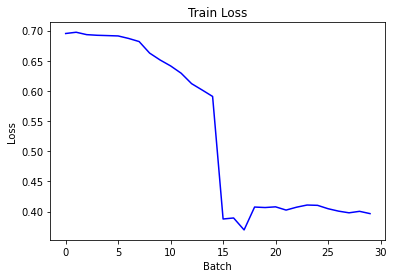

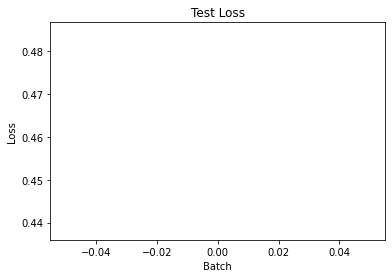

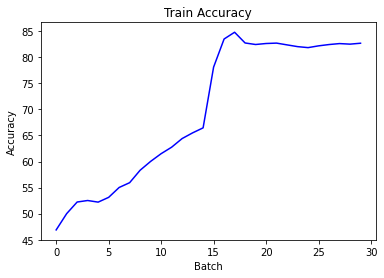

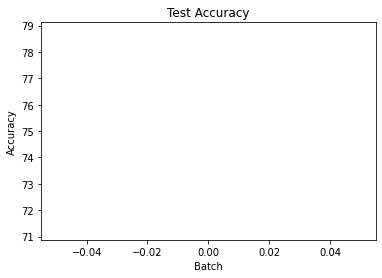

In [ ]:
plt.plot(train_loss_set,  color='blue')
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()


plt.plot(test_loss_set,  color='orange')
plt.title("Test Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")      
plt.show()


plt.plot(train_accuracy_set,  color='blue')
plt.title("Train Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")  
plt.show()


plt.plot(test_accuracy_set,  color='orange')
plt.title("Test Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")  
 
plt.show()

<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model. 

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

In [ ]:
output_model_file = 'pytorch_roberta_sentiment.pt'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


In [ ]:
train_data['text'][1]

"@Brandizzzle08 yoyoyo. my internet has been rude tonight. it JUST reconnected and I'm about to go to bed. "

In [ ]:
torch.save(model_to_save, '/content/gdrive/My Drive/ROBERTA20_4.pt')